In [1]:
!pip install clearml
#from clearml import Task

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.6 MB/s eta 0:00:00
  Attempting uninstall: pyjwt
    Found existing installation: PyJWT 2.7.0
    Uninstalling PyJWT-2.7.0:
      Successfully uninstalled PyJWT-2.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
beatrix-jupyterlab 2023.621.222118 requires jupyter-server~=1.16, but you have jupyter-server 2.6.0 which is incompatible.


In [2]:
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
# kaggle
%env CLEARML_API_ACCESS_KEY=IX8A3HY2QMNKNT0XK59H
%env CLEARML_API_SECRET_KEY=NbdCxqJt1sr7sxTlHF4xrO4tb1mD4I2jS21aSIWv8awOevptvK

env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=IX8A3HY2QMNKNT0XK59H
env: CLEARML_API_SECRET_KEY=NbdCxqJt1sr7sxTlHF4xrO4tb1mD4I2jS21aSIWv8awOevptvK


In [3]:
from clearml import Task
from tensorboardX import SummaryWriter

# init logger:
task = Task.init(project_name='Flower Recognition', task_name='PyTorch Flower Recognition using Transfer Learning')
writer = SummaryWriter('runs')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


ClearML Task: created new task id=f6788b25d1d94b6ca5bc80684ee47179
2023-10-04 03:12:28,934 - clearml.Repository Detection - WARNING - Failed accessing the jupyter server(s): []
2023-10-04 03:12:28,964 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.clear.ml/projects/e7501d816eb845eeab832661a929ae96/experiments/f6788b25d1d94b6ca5bc80684ee47179/output/log


### 1. Let's first view the distribution of the data

In [4]:
import os
paths = []
labels = []
for flower_type in os.listdir("/kaggle/input/flowers-recognition/flowers"):
    path_data = os.listdir(os.path.join("/kaggle/input/flowers-recognition/flowers",flower_type))
    cur_path = os.path.join("/kaggle/input/flowers-recognition/flowers",flower_type)
    paths.extend([os.path.join(cur_path,img) for img in path_data])
    labels.extend([flower_type]*len(path_data))

In [5]:
import pandas as pd
data = pd.DataFrame({"path":paths,"label":labels})

(-0.5, 319.5, 239.5, -0.5)

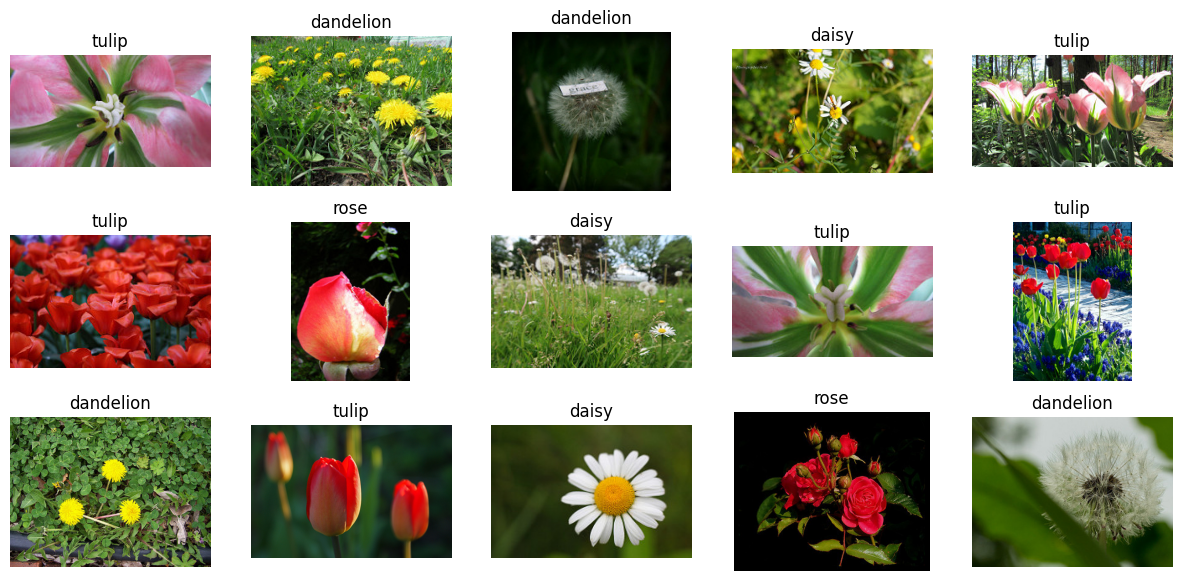

In [6]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

fig,ax=plt.subplots(3,5)
fig.set_size_inches(15,7)
for i in range(3):
    for j in range (5):
        l=np.random.randint(0,len(data.label))
        img = Image.open(data.path[l])
        ax[i,j].imshow(img)
        ax[i,j].set_title(data.label[l])
        ax[i,j].axis("off")
plt.axis('off')
#plt.tight_layout()

<Axes: >

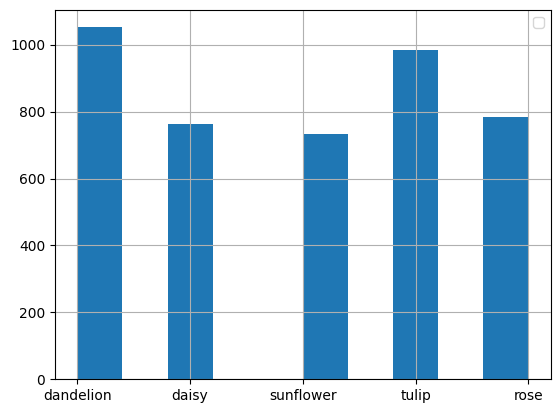

In [7]:
data.label.hist()

=> the data is balance

### 2. Data Loader and Custom Data Class

In [8]:
from PIL import Image
import os
import torch
from sklearn.model_selection import train_test_split

# define a data class
class ClassificationDataset:
    def __init__(self, data, data_path, transform, training=True):
        """Define the dataset for classification problems

        Args:
            data ([dataframe]): [a dataframe that contain 2 columns: image name and label]
            data_path ([str]): [path/to/folder that contains image file]
            transform : [augmentation methods and transformation of images]
            training (bool, optional): []. Defaults to True.
        """
        self.data = data
        self.imgs = data["path"].unique().tolist()
        self.data_path = data_path
        self.training = training
        self.transform = transform

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.data_path, self.data.iloc[idx, 0]))
        label = self.data.iloc[idx, 1]
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.imgs)


def make_loader(dataset, train_batch_size, validation_split=0.2):
    """make dataloader for pytorch training

    Args:
        dataset ([object]): [the dataset object]
        train_batch_size ([int]): [training batch size]
        validation_split (float, optional): [validation ratio]. Defaults to 0.2.

    Returns:
        [type]: [description]
    """
    # number of samples in train and test set
    train_len = int(len(dataset) * (1 - validation_split))
    test_len = len(dataset) - train_len
    train_set, test_set = torch.utils.data.random_split(dataset, [train_len, test_len])
    # create train_loader
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=train_batch_size, shuffle=True,
    )
    # create test_loader
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False,)
    return train_loader, test_loader


def data_split(data, test_size):
    x_train, x_test, y_train, y_test = train_test_split(
        data, data["label"], test_size=test_size, stratify = data.iloc[:,1]
    )
    return x_train, x_test, y_train, y_test

### Define Data Transform Strategy

In [9]:
import albumentations
from albumentations.pytorch import ToTensorV2

In [10]:
mean = (0.4124234616756439, 0.3674212694168091, 0.2578217089176178)
std = (0.3268945515155792, 0.29282665252685547, 0.29053378105163574)

In [11]:
import torchvision.transforms as transform
import torchvision
transformer = transform.Compose([
                           transform.Resize((224, 224)),
                           transform.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                           transform.RandomRotation(5),
                           transform.RandomAffine(degrees=11, translate=(0.1,0.1), scale=(0.8,0.8)),
                           transform.ToTensor(),
                           transform.Normalize(mean, std)
])

In [12]:
## mapping data
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data.label = le.fit_transform(data.label)

### Train test split

In [13]:
 x_train, x_test, y_train, y_test = data_split(data, test_size=0.3)

### implement data loaders for train/val/test

In [14]:
dataset = ClassificationDataset(x_train,data_path = "", transform=transformer, training=True)
train_loader, val_loader = make_loader(dataset, train_batch_size=32, validation_split=0.2)

In [15]:
test_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),
                                               torchvision.transforms.ToTensor(),
                                               transform.Normalize(mean, std)
                                                ])

In [16]:
testset = ClassificationDataset(x_test,data_path = "",transform=test_transform,training=False)
test_loader = torch.utils.data.DataLoader(
        testset, batch_size=1, shuffle=False,
    )

## 3. Define Metrics and Optimizers and Loss function

In [17]:
from sklearn import metrics as skmetrics
import numpy
class Metrics:
    def __init__(self, metric_names):
        self.metric_names = metric_names
        # initialize a metric dictionary
        self.metric_dict = {metric_name: [0] for metric_name in self.metric_names}

    def step(self, labels, preds):
        for metric in self.metric_names:
            # get the metric function
            do_metric = getattr(
                skmetrics, metric, "The metric {} is not implemented".format(metric)
            )
            # check if metric require average method, if yes set to 'micro' or 'macro' or 'None'
            try:
                self.metric_dict[metric].append(
                    do_metric(labels, preds, average="macro")
                )
            except:
                self.metric_dict[metric].append(do_metric(labels, preds))

    def epoch(self):
        # calculate metrics for an entire epoch
        avg = [sum(metric) / (len(metric) - 1) for metric in self.metric_dict.values()]
        metric_as_dict = dict(zip(self.metric_names, avg))
        return metric_as_dict

    def last_step_metrics(self):
        # return metrics of last steps
        values = [self.metric_dict[metric][-1] for metric in self.metric_names]
        metric_as_dict = dict(zip(self.metric_names, values))
        return metric_as_dict

In [18]:
train_metrics = Metrics(["accuracy_score", "f1_score"])
val_metrics = Metrics(["accuracy_score", "f1_score"])

In [19]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch import nn
criterion = nn.CrossEntropyLoss()

In [20]:
device

device(type='cuda')

## 4. Define the Model: Transfer Learning

In [21]:
from torchvision import models
from torch import nn

model = models.efficientnet_b4(pretrained=True).cuda()

for param in model.parameters():
    param.requires_grad = True

classifier = nn.Sequential(
    nn.Linear(in_features=model.classifier[1].in_features, out_features=256,bias=True),
    nn.Linear(in_features=256, out_features=5,bias=True)
)
model.classifier  = classifier

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth
100%|██████████| 74.5M/74.5M [00:02<00:00, 27.0MB/s]


2023-10-04 03:12:51,295 - clearml.model - INFO - Selected model id: c595f0ee98d64369b0e0d9d04578ecf0


In [22]:
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "min", patience=2, factor=0.5
    )

## 5. Define a training epoch

In [23]:
model = model.to(device)

In [24]:
def train_one_epoch(
    model,
    train_loader,
    test_loader,
    device,
    optimizer,
    criterion,
    train_metrics,
    val_metrics,
):

    # training-the-model
    train_loss = 0
    valid_loss = 0
    all_labels = []
    all_preds = []
    model.train()
    for data, target in train_loader:
        # move-tensors-to-GPU
        data = data.type(torch.FloatTensor).to(device)
        # target=torch.Tensor(target)
        target = target.float().to(device)
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # get the prediction label and target label
        output = model(data)
        preds = torch.argmax(output, axis=1).cpu().detach().numpy()
        labels = target.cpu().numpy()
        # calculate-the-batch-loss
        loss = criterion(output.type(torch.FloatTensor), target.type(torch.LongTensor))
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        # calculate training metrics
        all_labels.extend(labels)
        all_preds.extend(preds)
    
    train_metrics.step(all_labels, all_preds)

    # validate-the-model
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for data, target in test_loader:
            data = data.type(torch.FloatTensor).to(device)
            target = target.to(device)
            output = model(data)
            preds = torch.argmax(output, axis=1).tolist()
            labels = target.tolist()
            all_labels.extend(labels)
            all_preds.extend(preds)
            loss = criterion(output, target)

            # update-average-validation-loss
            valid_loss += loss.item() * data.size(0)

    val_metrics.step(all_labels, all_preds)
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(test_loader.sampler)

    return (
        train_loss,
        valid_loss,
        train_metrics.last_step_metrics(),
        val_metrics.last_step_metrics(),
    )

## 6. Begin Training

In [25]:
from tqdm import tqdm

from datetime import datetime
time_str = str(datetime.now().strftime("%Y%m%d-%H%M"))

In [26]:
num_epoch = 20
best_val_acc = 0

import logging
import numpy as np
print("begin training process")

for i in tqdm(range(0, num_epoch)):
    loss, val_loss, train_result, val_result = train_one_epoch(
        model,
        train_loader,
        val_loader,
        device,
        optimizer,
        criterion,
        train_metrics,
        val_metrics,
    )

    scheduler.step(val_loss)
    print(
        "Epoch {} / {} \n Training loss: {} - Other training metrics: ".format(
            i + 1, num_epoch, loss
        )
    )
    print(train_result)
    print(
        " \n Validation loss : {} - Other validation metrics:".format(val_loss)
    )
    print(val_result)
    print("\n")
    # saving epoch with best validation accuracy
    if best_val_acc < float(val_result["accuracy_score"]):
        print(
            "Validation accuracy= "+
            str(val_result["accuracy_score"])+
            "===> Save best epoch"
        )
        best_val_acc = val_result["accuracy_score"]
        torch.save(
            model.state_dict(),
            "./" +  "best.pt",
        )
    else:
        print(
            "Validation accuracy= "+ str(val_result["accuracy_score"])+ "===> No saving"
        )
        continue

begin training process


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 / 20 
 Training loss: 0.7238772121683651 - Other training metrics: 
{'accuracy_score': 0.7566225165562914, 'f1_score': 0.7528831906939069}
 
 Validation loss : 0.49803769925383073 - Other validation metrics:
{'accuracy_score': 0.8347107438016529, 'f1_score': 0.8323595469640095}


Validation accuracy= 0.8347107438016529===> Save best epoch
2023-10-04 03:14:10,347 - clearml.frameworks - INFO - Found existing registered model id=c536a6b2c477411db7a3f265608f6e5d [/kaggle/working/best.pt] reusing it.


  5%|▌         | 1/20 [01:13<23:19, 73.67s/it]

Epoch 2 / 20 
 Training loss: 0.4483584566226858 - Other training metrics: 
{'accuracy_score': 0.8389900662251656, 'f1_score': 0.836766800217679}
 
 Validation loss : 0.4475415622532777 - Other validation metrics:
{'accuracy_score': 0.8479338842975207, 'f1_score': 0.8477763799607863}


Validation accuracy= 0.8479338842975207===> Save best epoch


 10%|█         | 2/20 [02:06<18:28, 61.57s/it]

Epoch 3 / 20 
 Training loss: 0.3943834255467977 - Other training metrics: 
{'accuracy_score': 0.8613410596026491, 'f1_score': 0.8604626793752603}
 
 Validation loss : 0.41855619216522644 - Other validation metrics:
{'accuracy_score': 0.8512396694214877, 'f1_score': 0.8490865044606245}


Validation accuracy= 0.8512396694214877===> Save best epoch


 20%|██        | 4/20 [03:49<14:33, 54.59s/it]

Epoch 4 / 20 
 Training loss: 0.36893076602591585 - Other training metrics: 
{'accuracy_score': 0.8683774834437086, 'f1_score': 0.8661512007948721}
 
 Validation loss : 0.4343920272667358 - Other validation metrics:
{'accuracy_score': 0.8462809917355372, 'f1_score': 0.8459209512454275}


Validation accuracy= 0.8462809917355372===> No saving
Epoch 5 / 20 
 Training loss: 0.34583207984633796 - Other training metrics: 
{'accuracy_score': 0.8799668874172185, 'f1_score': 0.8780269021141868}
 
 Validation loss : 0.43188710459272284 - Other validation metrics:
{'accuracy_score': 0.8644628099173554, 'f1_score': 0.8635335707394531}


Validation accuracy= 0.8644628099173554===> Save best epoch


 30%|███       | 6/20 [05:32<12:17, 52.69s/it]

Epoch 6 / 20 
 Training loss: 0.3360477847768771 - Other training metrics: 
{'accuracy_score': 0.8774834437086093, 'f1_score': 0.8762461388905101}
 
 Validation loss : 0.44610016489994053 - Other validation metrics:
{'accuracy_score': 0.8347107438016529, 'f1_score': 0.8326525104665521}


Validation accuracy= 0.8347107438016529===> No saving


 35%|███▌      | 7/20 [06:23<11:17, 52.12s/it]

Epoch 7 / 20 
 Training loss: 0.3098787008630519 - Other training metrics: 
{'accuracy_score': 0.8878311258278145, 'f1_score': 0.8867053518120903}
 
 Validation loss : 0.42259134472376464 - Other validation metrics:
{'accuracy_score': 0.8429752066115702, 'f1_score': 0.8403408832211223}


Validation accuracy= 0.8429752066115702===> No saving


 40%|████      | 8/20 [07:14<10:19, 51.66s/it]

Epoch 8 / 20 
 Training loss: 0.3070010572474524 - Other training metrics: 
{'accuracy_score': 0.8861754966887417, 'f1_score': 0.885383305491291}
 
 Validation loss : 0.40518088815714004 - Other validation metrics:
{'accuracy_score': 0.856198347107438, 'f1_score': 0.8536386845458257}


Validation accuracy= 0.856198347107438===> No saving


 45%|████▌     | 9/20 [08:04<09:22, 51.14s/it]

Epoch 9 / 20 
 Training loss: 0.30365106581852136 - Other training metrics: 
{'accuracy_score': 0.8886589403973509, 'f1_score': 0.888141381886895}
 
 Validation loss : 0.3873183099545135 - Other validation metrics:
{'accuracy_score': 0.859504132231405, 'f1_score': 0.8578433080465979}


Validation accuracy= 0.859504132231405===> No saving


 50%|█████     | 10/20 [08:54<08:30, 51.02s/it]

Epoch 10 / 20 
 Training loss: 0.2780902737023815 - Other training metrics: 
{'accuracy_score': 0.9019039735099338, 'f1_score': 0.9013683333252512}
 
 Validation loss : 0.4072461190619036 - Other validation metrics:
{'accuracy_score': 0.8479338842975207, 'f1_score': 0.8460483174196085}


Validation accuracy= 0.8479338842975207===> No saving


 55%|█████▌    | 11/20 [09:44<07:35, 50.62s/it]

Epoch 11 / 20 
 Training loss: 0.27173224249422945 - Other training metrics: 
{'accuracy_score': 0.9035596026490066, 'f1_score': 0.9035232339591909}
 
 Validation loss : 0.4099823067063846 - Other validation metrics:
{'accuracy_score': 0.8528925619834711, 'f1_score': 0.8527153607380921}


Validation accuracy= 0.8528925619834711===> No saving


 60%|██████    | 12/20 [10:34<06:42, 50.36s/it]

Epoch 12 / 20 
 Training loss: 0.28156311444888843 - Other training metrics: 
{'accuracy_score': 0.8981788079470199, 'f1_score': 0.8972128974454844}
 
 Validation loss : 0.40804434889573377 - Other validation metrics:
{'accuracy_score': 0.856198347107438, 'f1_score': 0.85440878841801}


Validation accuracy= 0.856198347107438===> No saving


 65%|██████▌   | 13/20 [11:24<05:51, 50.21s/it]

Epoch 13 / 20 
 Training loss: 0.2768947250203581 - Other training metrics: 
{'accuracy_score': 0.9019039735099338, 'f1_score': 0.9008053575014323}
 
 Validation loss : 0.43444680852528955 - Other validation metrics:
{'accuracy_score': 0.8512396694214877, 'f1_score': 0.8488163375943932}


Validation accuracy= 0.8512396694214877===> No saving


 70%|███████   | 14/20 [12:13<05:00, 50.00s/it]

Epoch 14 / 20 
 Training loss: 0.2764808983597534 - Other training metrics: 
{'accuracy_score': 0.8952814569536424, 'f1_score': 0.8938435132679036}
 
 Validation loss : 0.44280002241626565 - Other validation metrics:
{'accuracy_score': 0.8528925619834711, 'f1_score': 0.8494807585667035}


Validation accuracy= 0.8528925619834711===> No saving


 75%|███████▌  | 15/20 [13:03<04:09, 49.90s/it]

Epoch 15 / 20 
 Training loss: 0.2494265567387966 - Other training metrics: 
{'accuracy_score': 0.9068708609271523, 'f1_score': 0.9056177851308977}
 
 Validation loss : 0.431897810711429 - Other validation metrics:
{'accuracy_score': 0.8545454545454545, 'f1_score': 0.8526186395194337}


Validation accuracy= 0.8545454545454545===> No saving


 80%|████████  | 16/20 [13:52<03:18, 49.71s/it]

Epoch 16 / 20 
 Training loss: 0.23939166519026092 - Other training metrics: 
{'accuracy_score': 0.9201158940397351, 'f1_score': 0.9200783084731581}
 
 Validation loss : 0.4160529577813958 - Other validation metrics:
{'accuracy_score': 0.8446280991735537, 'f1_score': 0.8415125253011432}


Validation accuracy= 0.8446280991735537===> No saving
Epoch 17 / 20 
 Training loss: 0.2416831400023391 - Other training metrics: 
{'accuracy_score': 0.9134933774834437, 'f1_score': 0.9122242134407241}
 
 Validation loss : 0.3685013486204866 - Other validation metrics:
{'accuracy_score': 0.8760330578512396, 'f1_score': 0.874318878072543}


Validation accuracy= 0.8760330578512396===> Save best epoch


 90%|█████████ | 18/20 [15:35<01:40, 50.37s/it]

Epoch 18 / 20 
 Training loss: 0.2247139187838068 - Other training metrics: 
{'accuracy_score': 0.9205298013245033, 'f1_score': 0.9199885769699951}
 
 Validation loss : 0.4084828487767362 - Other validation metrics:
{'accuracy_score': 0.8495867768595041, 'f1_score': 0.8495871722316544}


Validation accuracy= 0.8495867768595041===> No saving


 95%|█████████▌| 19/20 [16:24<00:50, 50.12s/it]

Epoch 19 / 20 
 Training loss: 0.24215177964690504 - Other training metrics: 
{'accuracy_score': 0.9139072847682119, 'f1_score': 0.9140334275614427}
 
 Validation loss : 0.42346195707430145 - Other validation metrics:
{'accuracy_score': 0.8545454545454545, 'f1_score': 0.850438735065319}


Validation accuracy= 0.8545454545454545===> No saving


100%|██████████| 20/20 [17:14<00:00, 51.75s/it]

Epoch 20 / 20 
 Training loss: 0.24436383906579176 - Other training metrics: 
{'accuracy_score': 0.9093543046357616, 'f1_score': 0.9075957550467286}
 
 Validation loss : 0.40546555341754914 - Other validation metrics:
{'accuracy_score': 0.8677685950413223, 'f1_score': 0.8643935563478935}


Validation accuracy= 0.8677685950413223===> No saving


## Test the results

In [27]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [28]:
import copy
test_model = copy.deepcopy(model)
test_model.load_state_dict(torch.load("/kaggle/working/best.pt"))
test_model = test_model.to(device)

2023-10-04 03:30:13,802 - clearml.model - INFO - Selected model id: c536a6b2c477411db7a3f265608f6e5d


In [29]:
def test_result(model, test_loader, device):
    # testing the model by turning model "Eval" mode
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for data, target in test_loader:
            # move-tensors-to-GPU
            data = data.to(device)
            target = target.to(device)
            # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
            output = model(data)
            prob = nn.Softmax(dim=1)
            # applying Softmax to results
            probs = prob(output)
            labels.extend(target.tolist())
            preds.extend(torch.argmax(probs, axis=1).tolist())
    return labels,preds

In [30]:
labels, preds = test_result(test_model, test_loader, device)

In [31]:
report = classification_report(labels, preds, digits=4,target_names=le.classes_)

cm = confusion_matrix(labels, preds)

In [32]:
print(report)

              precision    recall  f1-score   support

       daisy     0.9269    0.8865    0.9062       229
   dandelion     0.8717    0.9462    0.9074       316
        rose     0.9272    0.8128    0.8662       235
   sunflower     0.8914    0.8955    0.8934       220
       tulip     0.8697    0.9020    0.8856       296

    accuracy                         0.8927      1296
   macro avg     0.8974    0.8886    0.8918      1296
weighted avg     0.8944    0.8927    0.8924      1296



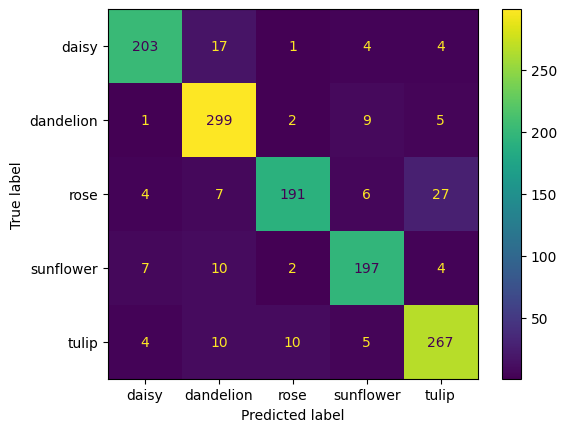

In [33]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot()

<Axes: >

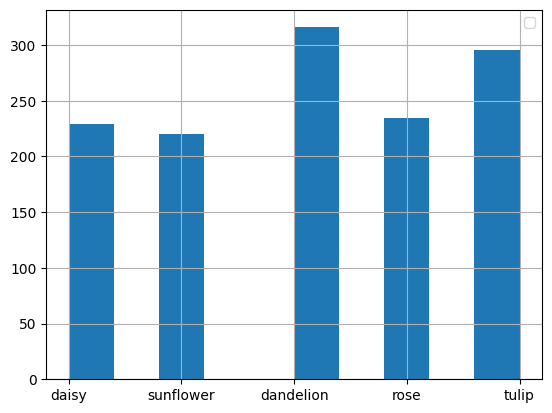

In [34]:
x_test.label = le.inverse_transform(x_test.label)
x_test.label.hist()